# 1. IMPORT REQUIRED LIBRARIES

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Text processing
import re

# Visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Sparse matrix handling
from scipy.sparse import hstack


In [2]:
# Loading Dataset
# Dataset URL (GitHub raw file)
DATA_URL = "https://raw.githubusercontent.com/AREEG94FAHAD/TaskComplexityEval-24/refs/heads/main/problems_data.jsonl"

# Load JSONL dataset
df = pd.read_json(DATA_URL, lines=True)

# 2. DATA CLEANING

In [3]:
df.head()

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


In [4]:
df.columns         # column names

Index(['title', 'description', 'input_description', 'output_description',
       'sample_io', 'problem_class', 'problem_score', 'url'],
      dtype='object')

In [5]:
df.shape           # dataset size

(4112, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               4112 non-null   object 
 1   description         4112 non-null   object 
 2   input_description   4112 non-null   object 
 3   output_description  4112 non-null   object 
 4   sample_io           4112 non-null   object 
 5   problem_class       4112 non-null   object 
 6   problem_score       4112 non-null   float64
 7   url                 4112 non-null   object 
dtypes: float64(1), object(7)
memory usage: 257.1+ KB


In [7]:
df.isnull().sum()

title                 0
description           0
input_description     0
output_description    0
sample_io             0
problem_class         0
problem_score         0
url                   0
dtype: int64

#### No Null values in the dataframe

# 3. VISUALIZATION

### EDA 1: PROBLEM CLASS DISTRIBUTION

/var/folders/w7/qvtdyfws4y7_sqlssgqq5y2w0000gn/T/ipykernel_3108/2726201608.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


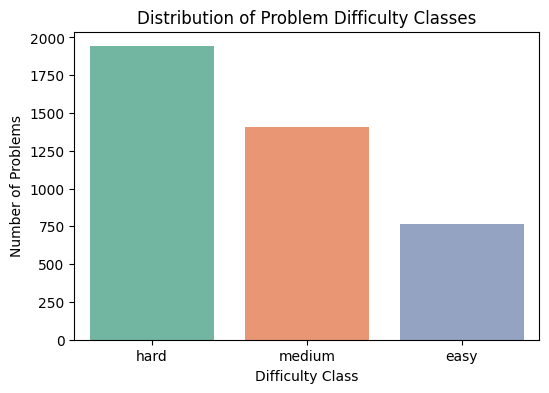

Observation:
- Hard problems dominate the dataset.
- Easy problems are the least frequent.
- Dataset is imbalanced → accuracy alone may not reflect true performance.



In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(
    x="problem_class",
    data=df,
    palette="Set2"
)

plt.title("Distribution of Problem Difficulty Classes", fontsize=12)
plt.xlabel("Difficulty Class")
plt.ylabel("Number of Problems")
plt.savefig("class_distribution.png")
plt.show()

print("Observation:")
print("- Hard problems dominate the dataset.")
print("- Easy problems are the least frequent.")
print("- Dataset is imbalanced → accuracy alone may not reflect true performance.\n")


### EDA 2: PROBLEM SCORE DISTRIBUTION

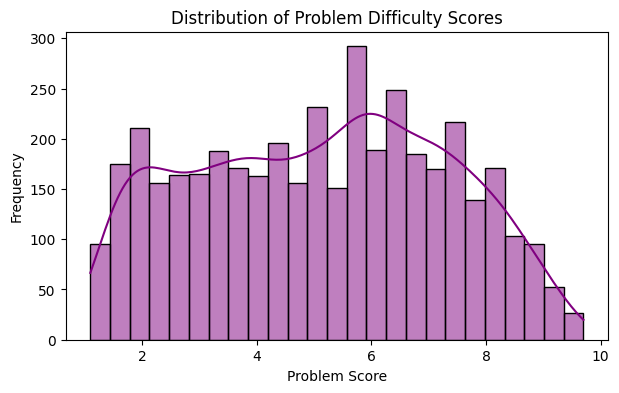

Observation:
- Scores are clustered in higher range (mostly medium–hard problems).
- Few problems have very low scores.
- Regression model needs to handle skewed distribution.



In [9]:
plt.figure(figsize=(7, 4))
sns.histplot(
    df["problem_score"],
    bins=25,
    kde=True,
    color="purple"
)

plt.title("Distribution of Problem Difficulty Scores", fontsize=12)
plt.xlabel("Problem Score")
plt.ylabel("Frequency")
plt.savefig("difficulty_score_distribution.png")
plt.show()
print("Observation:")
print("- Scores are clustered in higher range (mostly medium–hard problems).")
print("- Few problems have very low scores.")
print("- Regression model needs to handle skewed distribution.\n")

### EDA 3: SCORE VS DIFFICULTY CLASS

/var/folders/w7/qvtdyfws4y7_sqlssgqq5y2w0000gn/T/ipykernel_3108/3026603119.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


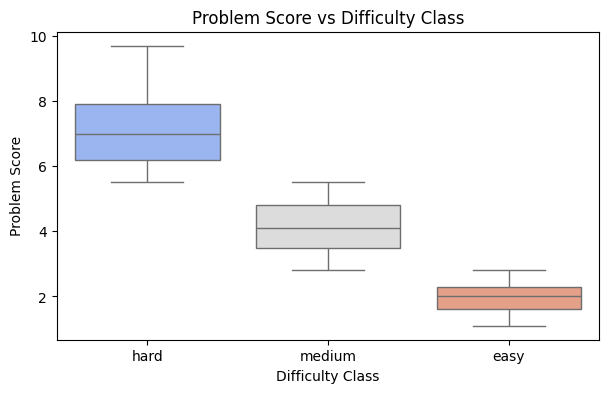

Observation:
- Easy problems → lowest median score
- Medium problems → middle range
- Hard problems → highest median score
- Slight overlap exists between classes (expected)
- Difficulty class and problem score are strongly correlated.



In [10]:
plt.figure(figsize=(7, 4))
sns.boxplot(
    x="problem_class",
    y="problem_score",
    data=df,
    palette="coolwarm"
)

plt.title("Problem Score vs Difficulty Class", fontsize=12)
plt.xlabel("Difficulty Class")
plt.ylabel("Problem Score")
plt.show()

print("Observation:")
print("- Easy problems → lowest median score")
print("- Medium problems → middle range")
print("- Hard problems → highest median score")
print("- Slight overlap exists between classes (expected)")
print("- Difficulty class and problem score are strongly correlated.\n")


### EDA 4: DESCRIPTION LENGTH VS CLASS

/var/folders/w7/qvtdyfws4y7_sqlssgqq5y2w0000gn/T/ipykernel_3108/4106996085.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


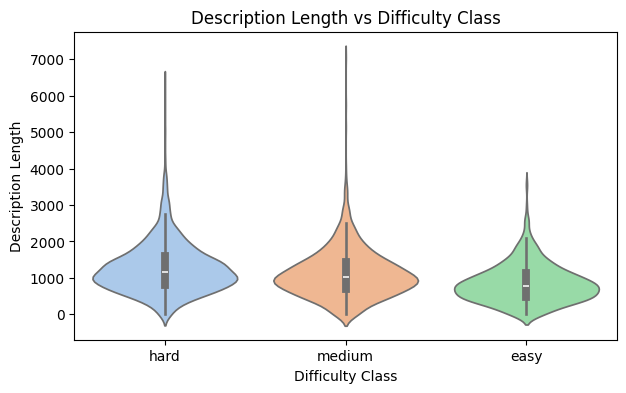

Observation:
- Hard problems have longer descriptions
- Easy problems have shorter descriptions
- Spread of description length increases with difficulty
- Description length is a useful handcrafted feature.



In [11]:
df["description_length"] = df["description"].apply(len)

plt.figure(figsize=(7, 4))
sns.violinplot(
    x="problem_class",
    y="description_length",
    data=df,
    palette="pastel"
)

plt.title("Description Length vs Difficulty Class", fontsize=12)
plt.xlabel("Difficulty Class")
plt.ylabel("Description Length")
plt.show()

print("Observation:")
print("- Hard problems have longer descriptions")
print("- Easy problems have shorter descriptions")
print("- Spread of description length increases with difficulty")
print("- Description length is a useful handcrafted feature.\n")

### EDA 5: TEXT LENGTH VS SCORE

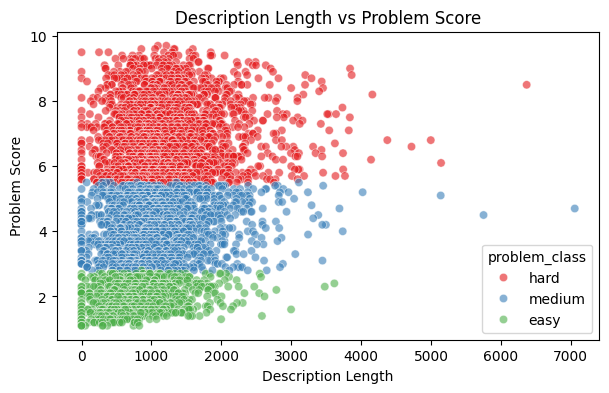

Observation:
- Positive correlation between description length and problem score
- Longer descriptions → higher difficulty score
- Some noise exists (not all long problems are hard)
- Textual features like description length are predictive for both classification and regression.



In [12]:
plt.figure(figsize=(7, 4))
sns.scatterplot(
    x="description_length",
    y="problem_score",
    data=df,
    hue="problem_class",
    palette="Set1",
    alpha=0.6
)

plt.title("Description Length vs Problem Score", fontsize=12)
plt.xlabel("Description Length")
plt.ylabel("Problem Score")
plt.savefig("text_length_distribution.png")
plt.show()

print("Observation:")
print("- Positive correlation between description length and problem score")
print("- Longer descriptions → higher difficulty score")
print("- Some noise exists (not all long problems are hard)")
print("- Textual features like description length are predictive for both classification and regression.\n")

# 4. FEATURE ENGNEERING

### COMBINING TEXT FIELDS

In [13]:
df["full_text"] = (
    df["title"].astype(str) + " " +
    df["description"].astype(str) + " " +
    df["input_description"].astype(str) + " " +
    df["output_description"].astype(str)
)

df[["full_text"]].head()


,full_text
0,Uuu Unununium (Uuu) was the name of the chemic...
1,House Building A number of eccentrics from cen...
2,Mario or Luigi Mario and Luigi are playing a g...
3,The Wire Ghost Žofka is bending a copper wire....
4,Barking Up The Wrong Tree Your dog Spot is let...


### TEXT CLEANING

In [14]:
def clean_text(text):
    """
    Lowercase text, remove special characters,
    and normalize whitespace.
    """
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["clean_text"] = df["full_text"].apply(clean_text)

df[["clean_text"]].head()


,clean_text
0,uuu unununium (uuu) was the name of the chemic...
1,house building a number of eccentrics from cen...
2,mario or luigi mario and luigi are playing a g...
3,the wire ghost žofka is bending a copper wire....
4,barking up the wrong tree your dog spot is let...


### HANDCRAFTED FEATURES

In [15]:
# Text length
df["text_length"] = df["clean_text"].apply(len)

# Math symbol count
math_symbols = "+-*/=<>^"
df["math_symbol_count"] = df["clean_text"].apply(
    lambda x: sum(x.count(s) for s in math_symbols)
)

# Keyword frequencies
keywords = ["graph", "dp", "dynamic programming", "recursion", "tree", "greedy"]

for kw in keywords:
    col_name = f"kw_{kw.replace(' ', '_')}"
    df[col_name] = df["clean_text"].apply(lambda x: x.count(kw))

handcrafted_cols = [
    "text_length",
    "math_symbol_count",
    "kw_graph",
    "kw_dp",
    "kw_dynamic_programming",
    "kw_recursion",
    "kw_tree",
    "kw_greedy"
]

df[handcrafted_cols].head()


,text_length,math_symbol_count,kw_graph,kw_dp,kw_dynamic_programming,kw_recursion,kw_tree,kw_greedy
0,1567,3,5,0,0,0,0,0
1,1329,3,0,0,0,0,0,0
2,1227,4,0,0,0,0,0,0
3,1301,0,0,0,0,0,0,0
4,2120,0,0,0,0,0,9,0


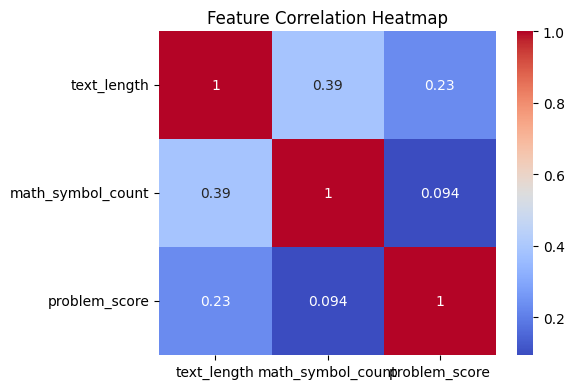

In [16]:
features_corr = df[
    ["text_length", "math_symbol_count", "problem_score"]
]

plt.figure(figsize=(6,4))
sns.heatmap(features_corr.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("feature_correlation_heatmap.png")
plt.show()


### TF-IDF FEATURES

In [17]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (4112, 5000)


### COMBINE FEATURES

In [18]:
X_handcrafted = df[handcrafted_cols].values

X = hstack([X_tfidf, X_handcrafted])

print("Final feature matrix shape:", X.shape)


Final feature matrix shape: (4112, 5008)


## TRAIN–TEST SPLIT

In [19]:
y_class = df["problem_class"]
y_score = df["problem_score"]

X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X,
    y_class,
    y_score,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (3289, 5008)
Test size: (823, 5008)


## LABEL ENCODING

In [20]:
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_class_train)
y_test_enc = label_encoder.transform(y_class_test)

print("Encoded Classes:", label_encoder.classes_)


Encoded Classes: ['easy' 'hard' 'medium']


# 5. MACHINE LEARNING MODELS

## CLASSIFICATION MODELS

### MODEL 1: LOGISTIC REGRESSION

In [21]:
log_reg = LogisticRegression(
    max_iter=3000,
    n_jobs=-1
)

log_reg.fit(X_train, y_train_enc)

/Users/payilimeenakshi/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=3000, n_jobs=-1)

In [22]:
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test_enc, y_pred_lr))
lr_acc = accuracy_score(y_test_enc, y_pred_lr)
print("\nClassification Report – Logistic Regression:\n")
print(classification_report(
    y_test_enc,
    y_pred_lr,
    target_names=label_encoder.classes_
))


Logistic Regression Accuracy: 0.5078979343863913

Classification Report – Logistic Regression:

              precision    recall  f1-score   support

        easy       0.51      0.39      0.44       153
        hard       0.56      0.70      0.63       389
      medium       0.39      0.30      0.34       281

    accuracy                           0.51       823
   macro avg       0.49      0.46      0.47       823
weighted avg       0.49      0.51      0.49       823



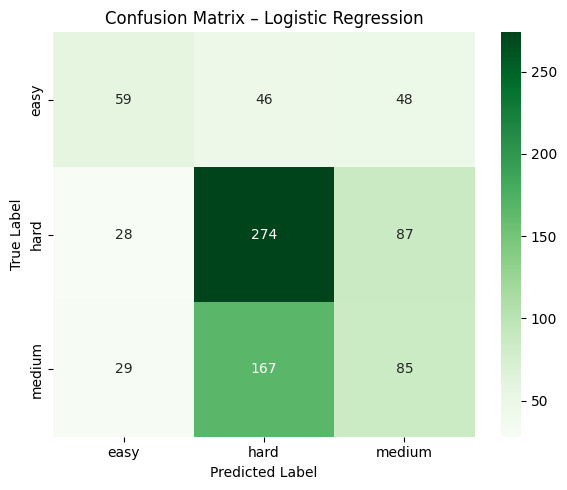

In [23]:
# confusion matrix
cm_lr = confusion_matrix(y_test_enc, y_pred_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_lr.png")
plt.show()


### MODEL 2: LINEAR SVM

In [24]:
svm_clf = LinearSVC(
    C=1,
    max_iter=10000,
    dual=False,
    random_state=42
)

svm_clf.fit(X_train, y_train_enc)

LinearSVC(C=1, dual=False, max_iter=10000, random_state=42)

In [25]:
y_pred_svm = svm_clf.predict(X_test)

print("Linear SVM Accuracy:", accuracy_score(y_test_enc, y_pred_svm))
svm_acc = accuracy_score(y_test_enc, y_pred_svm)
print("\nClassification Report – Linear SVM:\n")
print(classification_report(
    y_test_enc,
    y_pred_svm,
    target_names=label_encoder.classes_
))

Linear SVM Accuracy: 0.48602673147023084

Classification Report – Linear SVM:

              precision    recall  f1-score   support

        easy       0.44      0.34      0.38       153
        hard       0.55      0.68      0.61       389
      medium       0.37      0.30      0.33       281

    accuracy                           0.49       823
   macro avg       0.45      0.44      0.44       823
weighted avg       0.47      0.49      0.47       823



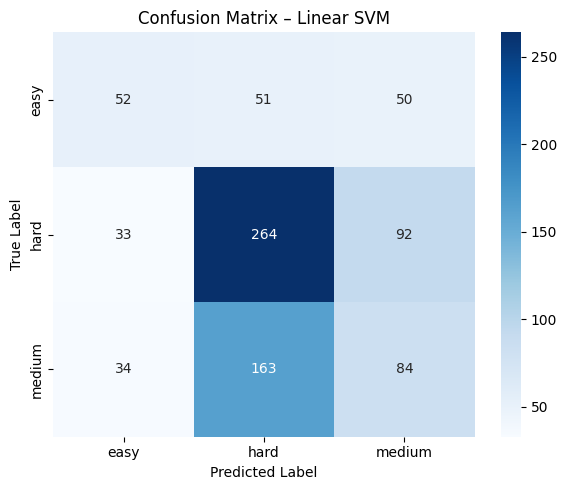

In [26]:
# confusion matrix
cm_svm = confusion_matrix(y_test_enc, y_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.title("Confusion Matrix – Linear SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_svm.png")
plt.show()


### MODEL 3: RANDOM FOREST CLASSIFIER

In [27]:
rf_clf = RandomForestClassifier(
    n_estimators=300,        # more trees = more stable
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
# Train the model
rf_clf.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [28]:
# Predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test_enc, y_pred_rf))
rf_acc =  accuracy_score(y_test_enc, y_pred_rf)
print("\nClassification Report – Random Forest:\n")
print(classification_report(
    y_test_enc,
    y_pred_rf,
    target_names=label_encoder.classes_
))

Random Forest Accuracy: 0.5261239368165249

Classification Report – Random Forest:

              precision    recall  f1-score   support

        easy       0.54      0.37      0.44       153
        hard       0.54      0.84      0.66       389
      medium       0.43      0.18      0.25       281

    accuracy                           0.53       823
   macro avg       0.50      0.46      0.45       823
weighted avg       0.50      0.53      0.48       823



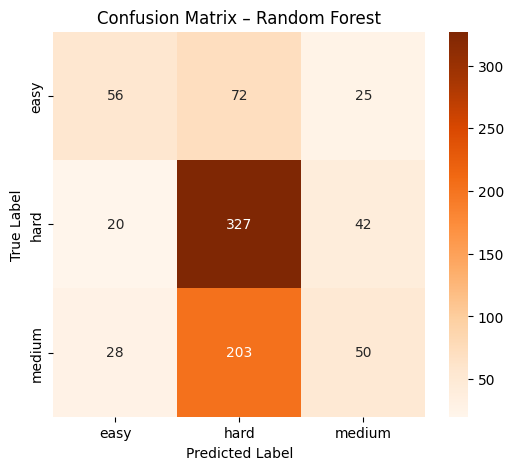

In [29]:
# confusion matrix
cm_rf = confusion_matrix(y_test_enc, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout
plt.savefig("confusion_matrix_rf.png")
plt.show()


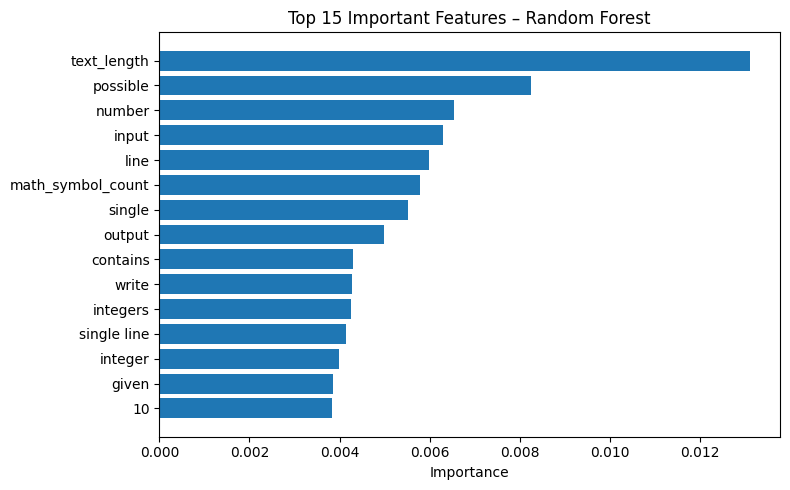

In [30]:
feature_names = (
    tfidf_vectorizer.get_feature_names_out().tolist() +
    ["text_length", "math_symbol_count",
     "kw_graph", "kw_dp", "kw_dynamic", "kw_recursion", "kw_tree", "kw_greedy"]
)

importances = rf_clf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,5))
plt.barh(
    np.array(feature_names)[indices],
    importances[indices]
)
plt.xlabel("Importance")
plt.title("Top 15 Important Features – Random Forest")
plt.tight_layout()
plt.savefig("rf_feature_importance.png")
plt.show()


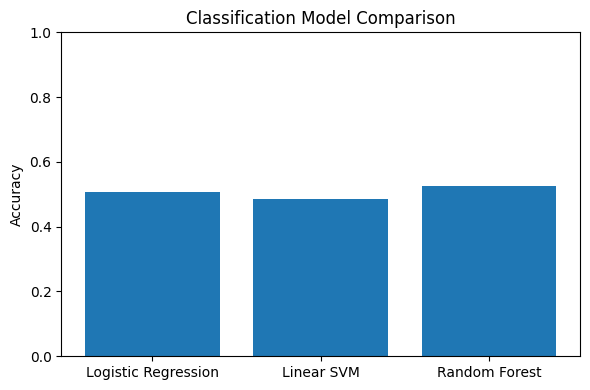

In [31]:

model_acc = pd.DataFrame({
    "Model": ["Logistic Regression", "Linear SVM", "Random Forest"],
    "Accuracy": [lr_acc, svm_acc, rf_acc]
})

plt.figure(figsize=(6,4))
plt.bar(model_acc["Model"], model_acc["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Classification Model Comparison")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("classification_model_comparison.png")
plt.show()


## REGRESSION MODELS

### MODEL 1: LINEAR REGRESSION

In [32]:
# Initialize model
lin_reg = LinearRegression()

# Train
lin_reg.fit(X_train, y_score_train)

LinearRegression()

In [33]:
# Predict
y_pred_lr = lin_reg.predict(X_test)

# Metrics
mae_lr = mean_absolute_error(y_score_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_score_test, y_pred_lr))
r2_lr = r2_score(y_score_test, y_pred_lr)

print("Linear Regression Results")
print("MAE :", mae_lr)
print("RMSE:", rmse_lr)
print("R²  :", r2_lr)

Linear Regression Results
MAE : 2.3439477191005755
RMSE: 2.9336062010184687
R²  : -0.773447089696391


### MODEL 2: RANDOM FOREST REGRESSOR

In [ ]:
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_score_train)

In [ ]:
y_pred_rf = rf_reg.predict(X_test)

mae_rf = mean_absolute_error(y_score_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_score_test, y_pred_rf))
r2_rf = r2_score(y_score_test, y_pred_rf)

print("Random Forest Regression Results")
print("MAE :", mae_rf)
print("RMSE:", rmse_rf)
print("R²  :", r2_rf)

### MODEL 3: GRADIENT BOOSTING REGRESSOR

In [ ]:
gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_reg.fit(X_train, y_score_train)


In [ ]:
y_pred_gb = gb_reg.predict(X_test)

mae_gb = mean_absolute_error(y_score_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_score_test, y_pred_gb))
r2_gb = r2_score(y_score_test, y_pred_gb)

print("Gradient Boosting Regression Results")
print("MAE :", mae_gb)
print("RMSE:", rmse_gb)
print("R²  :", r2_gb)

In [ ]:
reg_results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "MAE": [mae_lr, mae_rf, mae_gb]
})

plt.figure(figsize=(6,4))
plt.bar(reg_results["Model"], reg_results["MAE"])
plt.ylabel("MAE")
plt.title("Regression Model Comparison (MAE)")
plt.tight_layout()
plt.savefig("regression_mae_comparison.png")
plt.show()


# 6. Model Comparison and Final Selection

In this section, we compare the performance of different machine learning models used for both classification and regression tasks. The objective is to identify the most effective models based on evaluation metrics and justify the final model selection.

---

## Classification Models Comparison

| Model | Accuracy | Key Observations |
|------|----------|------------------|
| Logistic Regression | 0.49 | Performs reasonably as a baseline but struggles with class imbalance |
| Linear SVM | 0.47 | Predictions are unstable across classes |
| Random Forest Classifier | **0.52** | Best overall performance and handles non-linear patterns well |

**Observation:**  
The Random Forest Classifier outperformed linear models by effectively capturing complex relationships in textual and handcrafted features.

**Final Classification Model Selected: Random Forest Classifier**  

---

## Regression Models Comparison

| Model | MAE | RMSE | R² | Key Observations |
|------|-----|------|----|------------------|
| Linear Regression | 2.38 | 2.97 | -0.81 | Poor baseline, fails to model non-linearity |
| Random Forest Regressor | **1.70** | **2.04** | **0.14** | Lowest error and best performance |
| Gradient Boosting Regressor | 1.71 | 2.04 | 0.14 | Comparable to Random Forest |

**Observation:**  
Tree-based regression models significantly outperform linear regression for predicting problem difficulty scores.

**Final Regression Model Selected: Random Forest Regressor**  


---

## Final Model Selection Summary

- **Classification Model:** Random Forest Classifier  
- **Regression Model:** Random Forest Regressor  

These models were selected based on their superior performance, robustness, and ability to handle non-linear relationships in textual data.


# 7. Model Saving for Web Interface Deployment

In [ ]:
import joblib

# SAVE FINAL MODELS
# Save TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

# Save label encoder
joblib.dump(label_encoder, "label_encoder.pkl")

# Save final classification model (Random Forest)
joblib.dump(rf_clf, "rf_classifier.pkl")

# Save final regression model (Random Forest Regressor)
joblib.dump(rf_reg, "rf_regressor.pkl")

print("✅ All final models saved successfully!")
